
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 1 - Local Search <br>
<font color=696880 size=4>
Ali Aghayari


____

# Personal Data

In [1]:
# Set your student number
student_number = '401106182'
Name = 'Amirhossein'
Last_Name = 'Souri'

# Rules

<font color=red>
Please run all the cells.
</font>

# Libraries

In [2]:
!pip install tsp_solver2

In [3]:
# import libraries here
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time
import itertools
from tsp_solver.greedy import solve_tsp

# Q1: TSP problem

## Problem Definition

Consider the Euclidean  [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem):</br>
- In this problem, we are considering a country with n cities that are randomly placed; our country is a 1000 by 1000 square; we want to find the shortest tour for this country using their coordinates.
- A tour is a cycle that passes each city precisely one time.
- In this notebook we will develop some solutions to the problem, and more generally show how to think about solving a problem like this.



## Problem Representation (20 Points)

 We want to create our problem structure and present some valuable methods in this part.
 - init: choose your problem structure and create the variables accordingly.
 - distance: take two cities and return the distance between them.
 - tour length: get a tour and return the length of the given tour.
 - The shortest tour: get a set of tours and return the shortest one.
 - plot tour: get a tour and plot tour of the country.
 - nearest_neighbor: get a semi-tour and return to the nearest city to the last element you have yet to visit.

In [4]:
class TSP:
    n = 0
    cities = []
                      
    def __init__(self, num_cities, cities=None):
        self.n = num_cities
        self.cities = np.zeros((num_cities, 2))
        if cities is None:
            for i in range(num_cities):
                self.cities[i, 0] = random.randint(0, 999)
                self.cities[i, 1] = random.randint(0, 999)
        else:
            self.cities = cities

    def distance(self, A, B):
        Ax = self.cities[A, 0]
        Ay = self.cities[A, 1]
        Bx = self.cities[B, 0]
        By = self.cities[B, 1]
        return ((Ax - Bx) ** 2 + (Ay - By) ** 2) ** 0.5

    def tour_length(self, tour):
        length = 0
        for i in range(len(tour) - 1):
            length += self.distance(tour[i], tour[i + 1])
        return length

    def shortest_tour(self, tours):
        index = -1
        min_length = float('inf')
        for i in range(len(tours)):
            length = self.tour_length(tours[i])
            if length < min_length:
                index = i
                min_length = length
        return tours[index], min_length

    def plot_tour(self, tour):
        plt.plot(self.cities[tour, 0], self.cities[tour, 1], marker='o', color='b')
        plt.show()

    def nearest_neighbor(self, A, cities, count=None):
        distances = [[city, self.distance(A, city)] for city in cities]
        distances = sorted(distances, key=lambda x: x[1])
        if count is None:
            count = 1
        return list(np.array(distances)[:count, 0].astype('int32'))

## Brute Force (5 Points)

Let's start with an algorithm that is guaranteed to solve the problem (although it is inefficient for large sets of cities) </br>
we can achieve this by generating all possible tours of the cities and choosing the shortest tour (the one with minimum tour length).

In [5]:
def alltours_tsp(tsp):
    tours = [list(np.concatenate(([0], permute, [0]))) for permute in list(itertools.permutations(range(1, tsp.n)))]
    return tsp.shortest_tour(tours)

Now, try to create a country with five cities and apply your brute force function to find the shortest tour.

In [6]:
country = TSP(num_cities=5)
print(country.cities)
shortest_tour, min_length = alltours_tsp(country)
print("shortest tour path: %s\nshortest tour length: %d" % (shortest_tour, min_length))

[[417. 151.]
 [823. 965.]
 [273. 449.]
 [ 45.  84.]
 [439. 336.]]
shortest tour path: [0, 3, 2, 1, 4, 0]
shortest tour length: 2485


Visualize your answer for the TSP problem

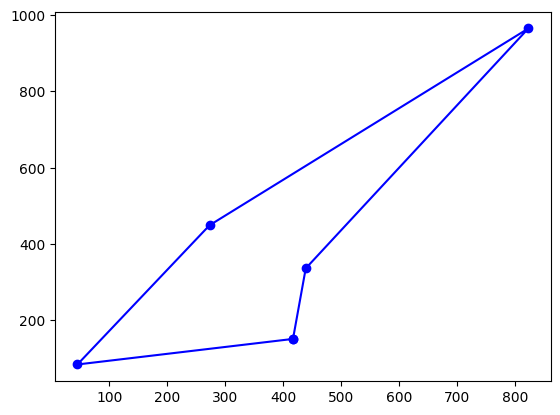

In [7]:
country.plot_tour(shortest_tour)



Try this algorithm on countries with 4, 6, 8, and 10 cities and plot the time it takes to calculate the answer.

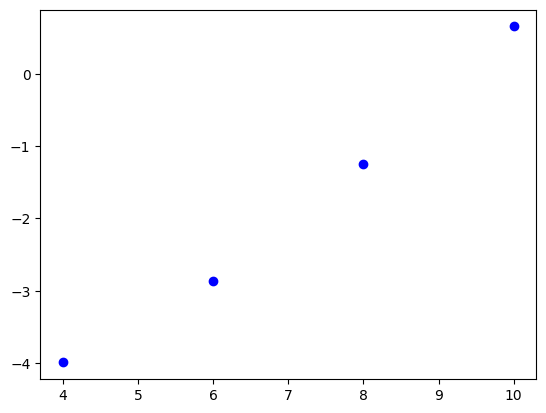

In [8]:
num_cities = [4, 6, 8, 10]
runtimes = []
for n in num_cities:
    country = TSP(num_cities=n)
    start = time.perf_counter()
    alltours_tsp(country)
    end = time.perf_counter()
    runtimes.append(math.log10(end - start))
plt.plot(num_cities, runtimes, 'bo')
plt.show()

## local Algorithms

### Initial Functions (25 Points)

We will create some functions for our initial state and use these functions for our local algorithms later.

- random initial function: Create a feasible tour randomly.

In [9]:
def random_initial(tsp):
    random_tour = list(np.random.permutation(range(tsp.n)))
    random_tour.append(random_tour[0])
    return random_tour, tsp.tour_length(random_tour)

- nearest neighbor initial function: Start at any city; at each step, extend the tour by moving from the previous city to its nearest neighbor that has yet to be visited.

In [10]:
def nearest_neighbor_initial(tsp):
    tour = []
    cities = list(range(tsp.n))
    current = random.randint(0, tsp.n - 1)
    tour.append(current)
    cities.remove(current)
    while len(cities) != 0:
        current = tsp.nearest_neighbor(current, cities)[0]
        tour.append(current)
        cities.remove(current)
        
    tour.append(tour[0])
    return tour, tsp.tour_length(tour)

- repeated nearest neighbor initial function : You can improve nearest neighbor algorithm by running it multiple times with different starting cities and using the best-generated answer.

In [11]:
def repeated_nearest_neighbor_initial(tsp, repetitions=None):
    if repetitions is None:
        repetitions = tsp.n
        
    starts = np.random.choice(range(tsp.n), repetitions, replace=False)
    min_length = float('inf')
    best_tour = []
    for current in starts:
        tour = []
        cities = list(range(tsp.n))
        tour.append(current)
        cities.remove(current)
        while len(cities) != 0:
            current = tsp.nearest_neighbor(current, cities)[0]
            cities.remove(current)
            tour.append(current)
        
        tour.append(tour[0])
        current_length = tsp.tour_length(tour)
        if current_length < min_length:
            best_tour = tour
            min_length = current_length
    
    return best_tour, min_length

Now, try to create a country with 30 cities, apply your repeated_nearest_neighbor_initial function with repetitions of 1, 4, 8, 12, and compare the results.

In [12]:
country = TSP(num_cities=30)
num_repititions = [1, 4, 8, 12]
tour_lengths = []
for k in num_repititions:
    tour_lengths.append(repeated_nearest_neighbor_initial(country, k)[1])
print(tour_lengths)

[5569.590999903801, 4939.102931853384, 4939.102931853385, 4939.102931853384]


Does repetition make our answer optimal? "Nope, but it increases the probability of finding the optimal solution"

- beam search initial function: Start with a list of n cities; at each step, extend your semi-tours by moving from their previous cities to their n nearest neighbors and then pick out n semi-tours from these generated semi-tours of length i+1

In [13]:
def beam_search_initial(tsp, n, iter):
    iter = tsp.n
    
    tours = []
    starts = np.random.choice(range(tsp.n), n, replace=False)
    for i in range(n):
        tours.append([[], 0, list(range(tsp.n))])
        tours[i][0].append(starts[i])
        tours[i][2].remove(starts[i])
        
    for i in range(iter - 1):
        temp = []
        for j in range(n):
            last_city = tours[j][0][i]
            neighbors = tsp.nearest_neighbor(last_city, tours[j][2], n)
            for k in range(len(neighbors)):
                temp_cities = tours[j][2].copy()
                temp_cities.remove(neighbors[k])
                temp.append([list(np.concatenate((tours[j][0], [neighbors[k]]))),
                             tours[j][1] + tsp.distance(last_city, neighbors[k]), temp_cities])
        temp = sorted(temp, key=lambda x: x[1])
        tours = temp[:n]

    for i in range(n):
        tours[i][0].append(tours[i][0][0])
        tours[i][1] = tours[i][1] + tsp.distance(tours[i][0][iter - 1], tours[i][0][iter])
    shortest_tour = sorted(tours, key=lambda x: x[1])[0]
    return shortest_tour[0], shortest_tour[1]

Now, try to create a country with 30 cities, apply these initial functions, and compare the tour length of these initial tours with each other and the optimal answer (if city_num is low).

In [14]:
country = TSP(num_cities=30)
random_tour, random_length = random_initial(country)
nn_tour, nn_length = nearest_neighbor_initial(country)
rnn_tour, rnn_length = repeated_nearest_neighbor_initial(country, 10)
beam_tour, beam_length = beam_search_initial(country, 5, 100)

print("random_initial length: %f" % random_length)
print("nearest_neighbor_initial length: %f" % nn_length)
print("repeated_nearest_neighbor_initial length: %f" % rnn_length)
print("beam_search_initial length: %f" % beam_length)

random_initial length: 12110.348294
nearest_neighbor_initial length: 4747.179693
repeated_nearest_neighbor_initial length: 4747.179693
beam_search_initial length: 4571.497504


Plot these tours and compare them visually.

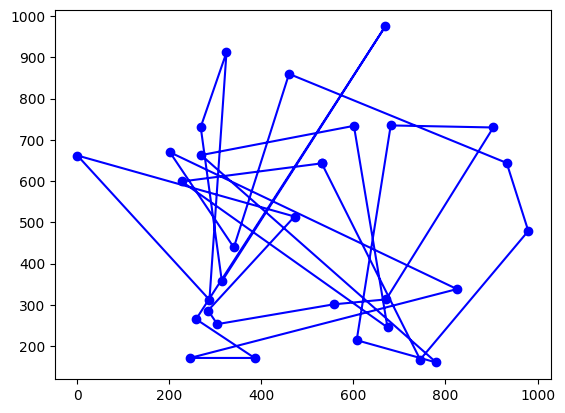

In [15]:
country.plot_tour(random_tour)

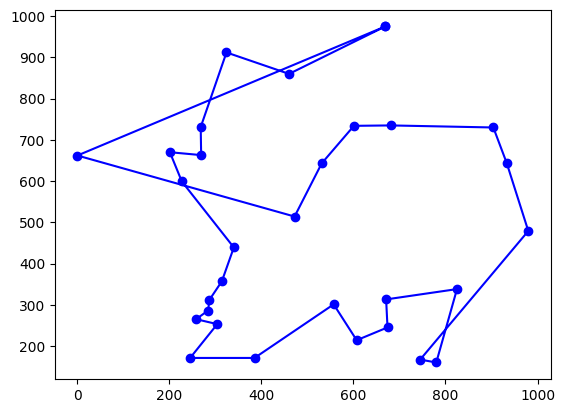

In [16]:
country.plot_tour(nn_tour)

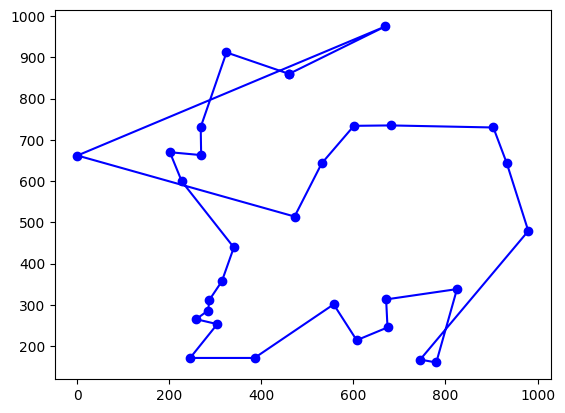

In [17]:
country.plot_tour(rnn_tour)

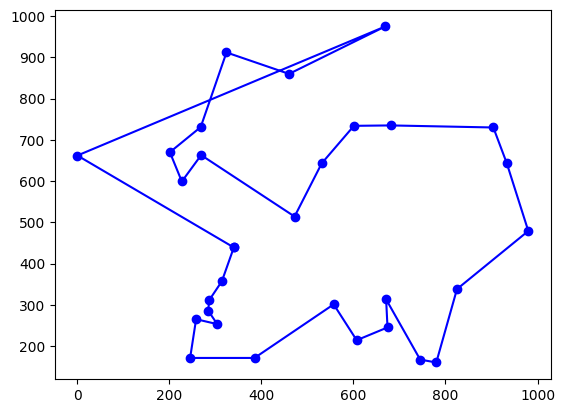

In [18]:
country.plot_tour(beam_tour)

### LKH (25 Points)

Implement a simplified version of [LKH](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwimj7nFoqCEAxWzh_0HHc98Df4QFnoECCQQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FLin%25E2%2580%2593Kernighan_heuristic&usg=AOvVaw0G05-wkkun1YAp6zPfWuLd&opi=89978449) for this problem.</br>
- This local search algorithm takes the initial state and improves it over time by swapping a part of the tour sequence.
- In this modified version, we will check every (i,j) pair at each iteration and reverse the tour from index "I" to index "J" if it improves our tour.


In [19]:
def lin_kernighan(tsp, initial, iterations=10):
    tour = initial

    for k in range(iterations):
        for i in range(1, tsp.n):
            for j in range(i + 1, tsp.n):
                reverse_tour = list(np.concatenate((tour[:i], tour[j:i - 1:-1], tour[j + 1:])).astype('int32'))
                if tsp.tour_length(reverse_tour) < tsp.tour_length(tour):
                    tour = reverse_tour
                    tour[tsp.n] = tour[0]
                    
    return tour, tsp.tour_length(tour)

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

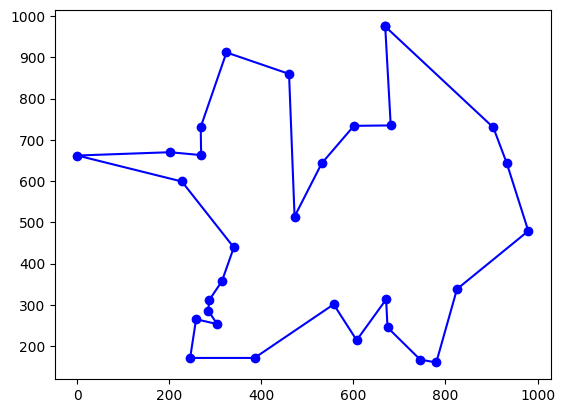

length: 4150.933703


In [20]:
shortest_tour, min_length = lin_kernighan(country, nn_tour)
country.plot_tour(shortest_tour)
print("length: %f" % min_length)

### Simulated Annealing (25 Points)

Implement simulated annealing for this problem.

In [21]:
def simulated_annealing(tsp, initial, initial_temperature=1000, cooling_rate=0.99, num_iterations=10000):
    tour = initial
    T = initial_temperature
    
    for _ in range(num_iterations):
        i = random.randint(1, tsp.n - 2)
        j = random.randint(i + 1, tsp.n - 1)
        neighbor = list(np.concatenate((tour[:i], tour[j:i - 1:-1], tour[j + 1:])).astype('int32'))
        neighbor[tsp.n] = neighbor[0]
        
        delta_length = tsp.tour_length(tour) - tsp.tour_length(neighbor)
        if delta_length > 0:
            tour = neighbor
        elif random.random() < (delta_length / T):
            tour = neighbor
        T *= cooling_rate
        
    return tour, tsp.tour_length(tour)

Run this algorithm on a reasonably big country and visualize it.</br>
You can use any initial state in this part.

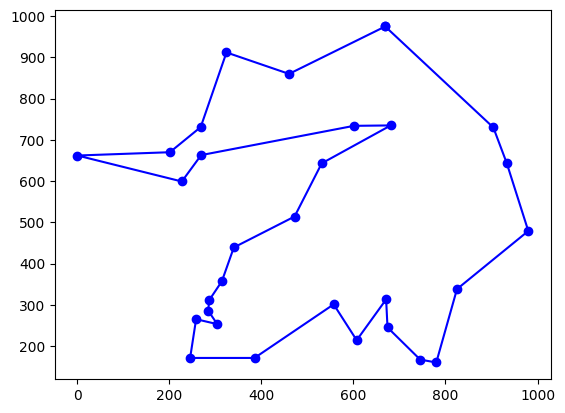

length: 4190.371907


In [22]:
shortest_tour, min_length = simulated_annealing(country, nn_tour)
country.plot_tour(shortest_tour)
print("length: %f" % min_length)

### Analysis

- The given code can calculate an acceptable approximated answer.
- use this code to compare your algorithms.

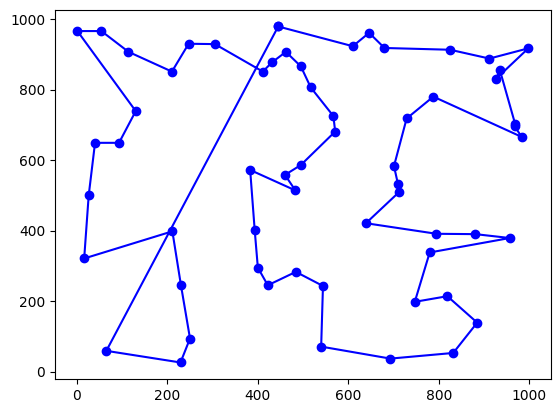

7127.997621647556


In [23]:
country = TSP(num_cities=60)

distances = []
for i in range(country.n):
    distances.append([])
    for j in range(country.n):
        distances[i].append(country.distance(i, j))

path = solve_tsp(distances)
path.append(path[0])
country.plot_tour(path)
print(country.tour_length(path))

- analyze the lengths you get from the two algorithms with different initial functions
- plot these tours and explain the results (results may be inconsistent as they are approximations)

threshold: 7127.997622
LKH | random --> 6828.525456
LKH | nearest nieghbor --> 6812.798583
LKH | repeated nearest neighbor --> 6619.809423
LKH | beam search --> 6709.315840
SA  | random --> 6767.728549
SA  | nearest nieghbor --> 6978.632437
SA  | repeated nearest neighbor --> 6418.716384
SA  | beam search --> 6688.639305


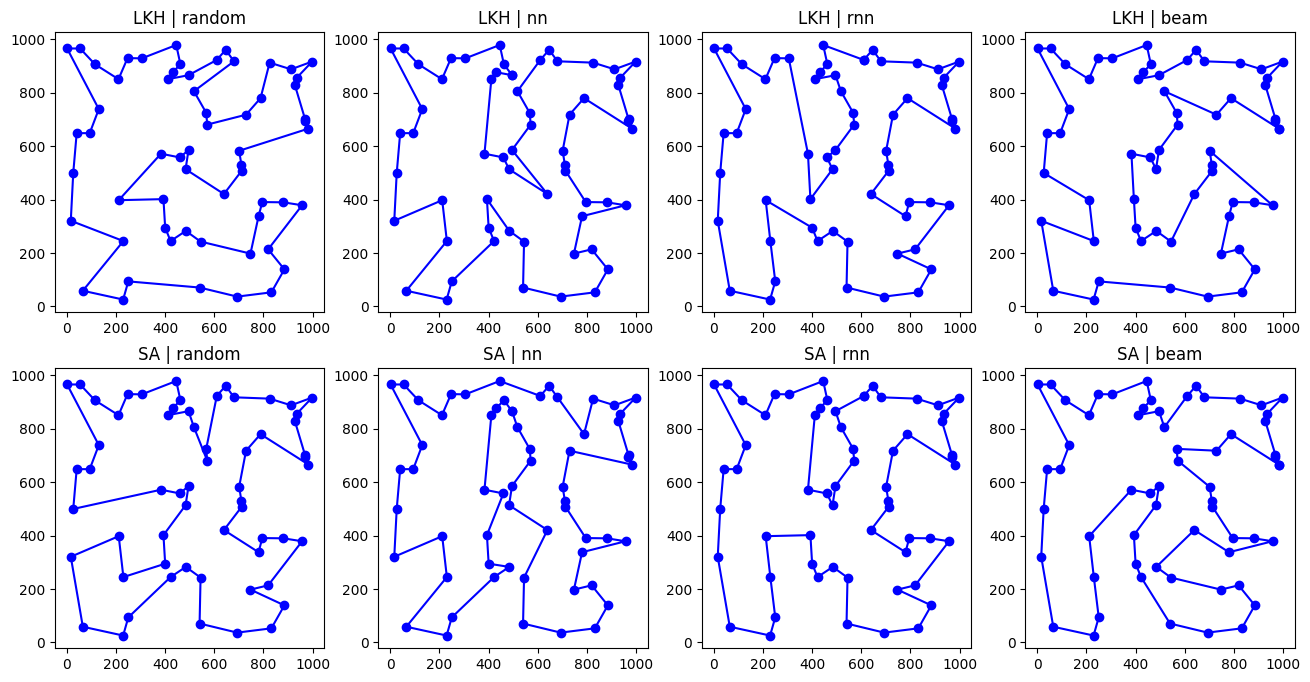

In [24]:
print('threshold: %f' % country.tour_length(path))

# << Lin-Kernighan >>
# random
random_tour = random_initial(country)[0]
random_lkh_tour, random_lkh_length = lin_kernighan(country, random_tour)
print('LKH | random --> %f' % random_lkh_length)

# nearest neighbor
nn_tour = nearest_neighbor_initial(country)[0]
nn_lkh_tour, nn_lkh_length = lin_kernighan(country, nn_tour)
print('LKH | nearest nieghbor --> %f' % nn_lkh_length)

# repeated nearest neighbor
rnn_tour = repeated_nearest_neighbor_initial(country, 10)[0]
rnn_lkh_tour, rnn_lkh_length = lin_kernighan(country, rnn_tour)
print('LKH | repeated nearest neighbor --> %f' % rnn_lkh_length)

# beam search
beam_tour = beam_search_initial(country, 5, 100)[0]
beam_lkh_tour, beam_lkh_length = lin_kernighan(country, beam_tour)
print('LKH | beam search --> %f' % beam_lkh_length)

# << Simulated Annealing >>
# random
random_sa_tour, random_sa_length = simulated_annealing(country, random_tour)
print('SA  | random --> %f' % random_sa_length)

# nearest neighbor
nn_sa_tour, nn_sa_length = simulated_annealing(country, nn_tour)
print('SA  | nearest nieghbor --> %f' % nn_sa_length)

# repeated nearest neighbor
rnn_sa_tour, rnn_sa_length = simulated_annealing(country, rnn_tour)
print('SA  | repeated nearest neighbor --> %f' % rnn_sa_length)

# beam search
beam_sa_tour, beam_sa_length = simulated_annealing(country, beam_tour)
print('SA  | beam search --> %f' %beam_sa_length)


# plot
plt.figure(figsize=(16, 8))
cities = country.cities

plt.subplot(2, 4, 1)
plt.title('LKH | random')
plt.plot(cities[random_lkh_tour, 0], cities[random_lkh_tour, 1], marker='o', color='b')

plt.subplot(2, 4, 2)
plt.title('LKH | nn')
plt.plot(cities[nn_lkh_tour, 0], cities[nn_lkh_tour, 1], marker='o', color='b')

plt.subplot(2, 4, 3)
plt.title('LKH | rnn')
plt.plot(cities[rnn_lkh_tour, 0], cities[rnn_lkh_tour, 1], marker='o', color='b')

plt.subplot(2, 4, 4)
plt.title('LKH | beam')
plt.plot(cities[beam_lkh_tour, 0], cities[beam_lkh_tour, 1], marker='o', color='b')

plt.subplot(2, 4, 5)
plt.title('SA | random')
plt.plot(cities[random_sa_tour, 0], cities[random_sa_tour, 1], marker='o', color='b')

plt.subplot(2, 4, 6)
plt.title('SA | nn')
plt.plot(cities[nn_sa_tour, 0], cities[nn_sa_tour, 1], marker='o', color='b')

plt.subplot(2, 4, 7)
plt.title('SA | rnn')
plt.plot(cities[rnn_sa_tour, 0], cities[rnn_sa_tour, 1], marker='o', color='b')

plt.subplot(2, 4, 8)
plt.title('SA | beam')
plt.plot(cities[beam_sa_tour, 0], cities[beam_sa_tour, 1], marker='o', color='b')

plt.show()